# Import Libraries

link to dataset 
https://data.mendeley.com/datasets/5y9wdsg2zt/2

In [18]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [53]:
# Create path to input files
positive_dir = r'C:/Users/ANAND/ML_Projects/ML/CrackDetection/inputs/Positive/*.jpg'
negative_dir = r'C:/Users/ANAND/ML_Projects/ML/CrackDetection/inputs/Negative/*.jpg'

In [54]:
# Create DataFrames
def generate_df(image_dir, label):
    filepaths = pd.Series(glob.glob(image_dir), name='Filepath')
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [55]:
df_positive = generate_df(positive_dir, label='POSITIVE')
df_negative = generate_df(negative_dir, label='NEGATIVE')
print(df_positive[1:5])
print(df_negative[0:5])

                                            Filepath     Label
1  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  POSITIVE
2  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  POSITIVE
3  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  POSITIVE
4  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  POSITIVE
                                            Filepath     Label
0  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  NEGATIVE
1  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  NEGATIVE
2  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  NEGATIVE
3  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  NEGATIVE
4  C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...  NEGATIVE


In [59]:
all_df = pd.concat([df_positive, df_negative], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df
print(type(all_df))
all_df.to_csv('All_data.csv')

<class 'pandas.core.frame.DataFrame'>


In [60]:
all_df.describe()

,Filepath,Label
count,40000,40000
unique,40000,2
top,C:/Users/ANAND/ML_Projects/ML/CrackDetection/i...,POSITIVE
freq,1,20000


In [61]:
# Train and Test data split
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [84]:
# Loading Image data
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [103]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label', 
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


Training

In [104]:
inputs = tf.keras.Input(shape=(120, 120, 3))

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [109]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, 
                    validation_data=val_data,
                    epochs=50, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=3,
                        restore_best_weights=True
                    )
                                ]
                   )

Epoch 1/50
105/105 [==============================] - 122s 1s/step - loss: 0.6855 - accuracy: 0.5551 - val_loss: 0.6688 - val_accuracy: 0.7083
Epoch 2/50
105/105 [==============================] - 16s 146ms/step - loss: 0.6370 - accuracy: 0.6804 - val_loss: 0.5904 - val_accuracy: 0.7429
Epoch 3/50
105/105 [==============================] - 14s 135ms/step - loss: 0.5285 - accuracy: 0.7964 - val_loss: 0.4945 - val_accuracy: 0.8131
Epoch 4/50
105/105 [==============================] - 14s 137ms/step - loss: 0.4331 - accuracy: 0.8842 - val_loss: 0.4072 - val_accuracy: 0.8571
Epoch 5/50
105/105 [==============================] - 14s 135ms/step - loss: 0.3509 - accuracy: 0.9179 - val_loss: 0.3038 - val_accuracy: 0.9238
Epoch 6/50
105/105 [==============================] - 15s 139ms/step - loss: 0.2840 - accuracy: 0.9390 - val_loss: 0.2428 - val_accuracy: 0.9310
Epoch 7/50
105/105 [==============================] - 14s 136ms/step - loss: 0.2479 - accuracy: 0.9372 - val_loss: 0.2244 - val_accu

In [110]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

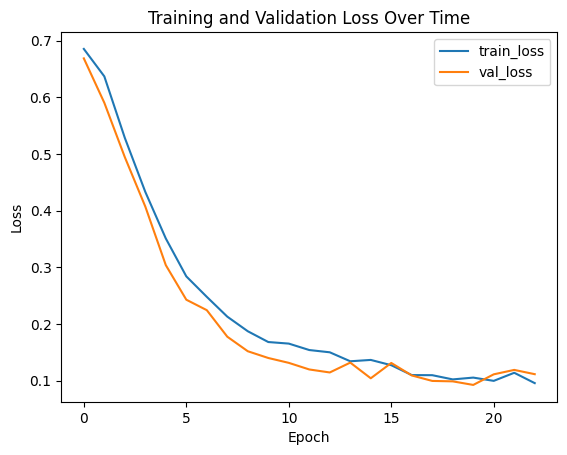

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

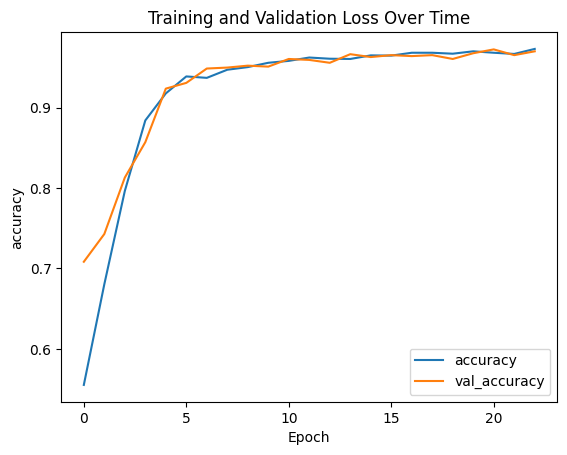

In [114]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [116]:
results = model.evaluate(test_data, verbose=0)
loss = results[0]
acc = results[1]

print("Test Loss: {:.5f}".format(loss))
print("Test Accuracy: {:.2f}%".format(acc * 100))
    
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

Test Loss: 0.08201
Test Accuracy: 97.61%
57/57 [==============================] - 4s 64ms/step


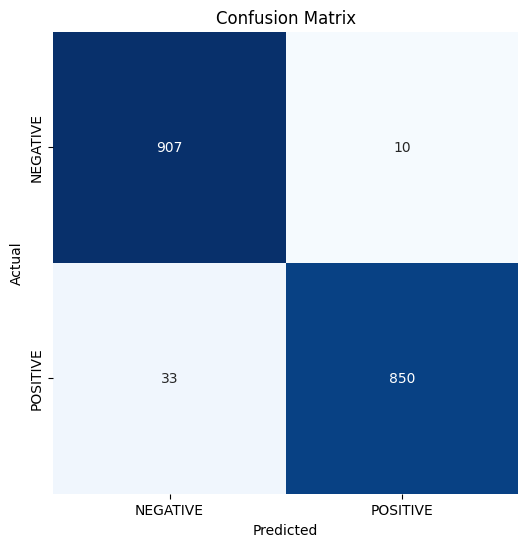

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.98       917
    POSITIVE       0.99      0.96      0.98       883

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [117]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)